# HW03: due October th

The goal of this homework is to **predict** the value of houses in California starting from house and neighborhood caracteristics.

Differently from last week's homework, we are not interested in investigating the causal effect of some features on house values, but the main purpose is to obtain good predictions of the values, so to train the best model to minimize the loss function.


In [1]:
# Load Data
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
print(data['DESCR'])


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [2]:
X_full, y_full = data.data, data.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
print(n_samples, n_features)


20640 8


# Summary Statistics


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


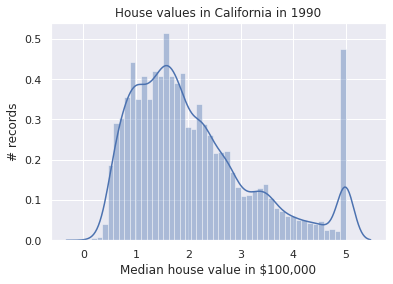

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


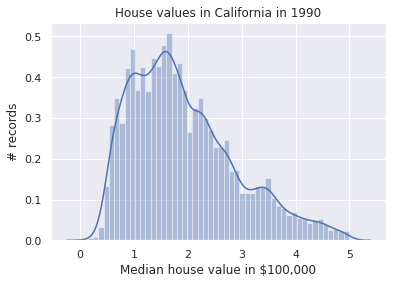

In [3]:
from seaborn import distplot, set_theme
from matplotlib.pyplot import show
# make a histogram of the label variable

set_theme()


def hist(
    target_variable,
    title='House values in California in 1990',
    xlabel='Median house value in $100,000',
    ylabel='# records'
):
    axes = distplot(target_variable)
    axes.set_title(title)
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    show()


hist(y_full)

# Data is skewed to the right and has a cap at $500,000

y_capped = y_full[y_full < 5]

hist(y_capped)


array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>, <AxesSubplot:>]],
      dtype=object)

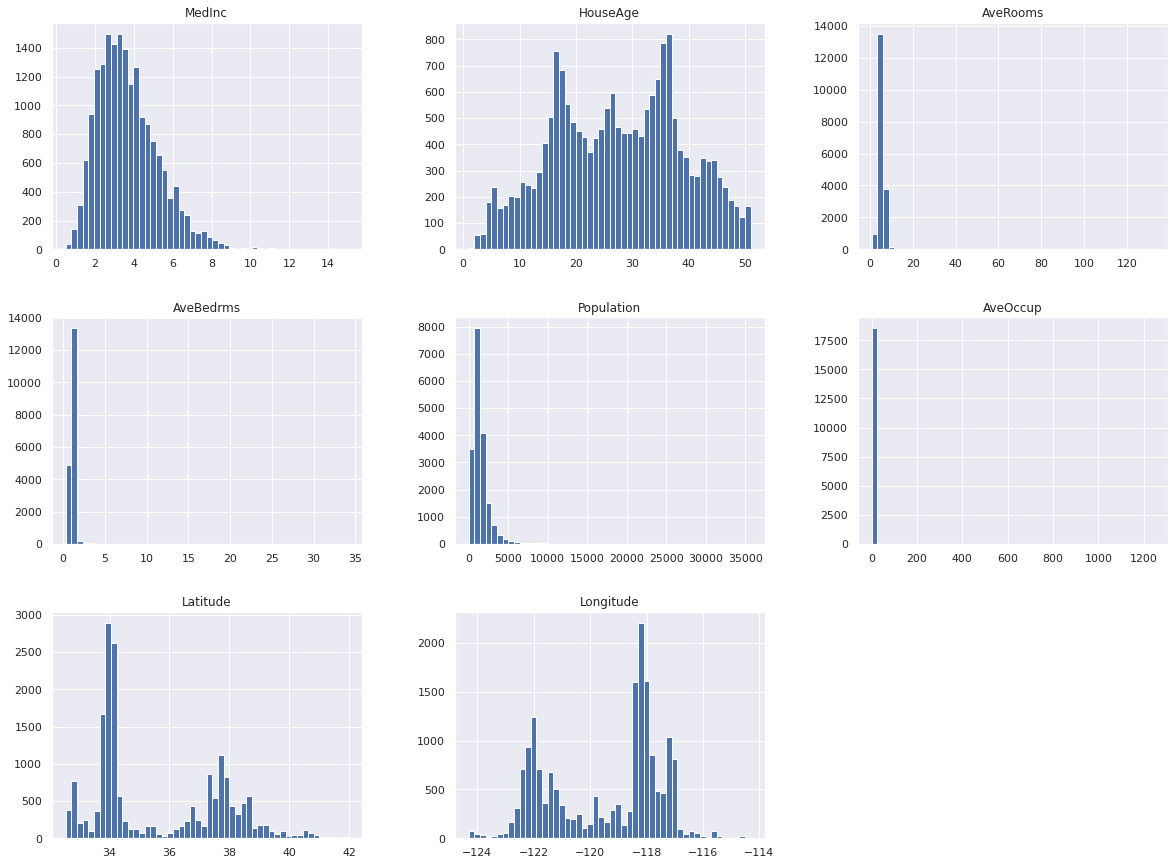

In [4]:
from pandas import DataFrame

# make histograms of all predictors

# It seems like HouseAge is capped at 52 years. Might want to drop those entries
X_df = DataFrame(X_full, columns=data.feature_names)

# Also create data frame corresponding to capped y values
X_df_capped = X_df[y_full < 5]

# Also remove capped entries for HouseAge
mask = X_df_capped['HouseAge'] < 52
X_df_capped = X_df_capped[mask]
y_capped = y_capped[mask]

# Remaining data seems OK

X_df_capped.hist(bins=50, figsize=(20, 15))



In [5]:
X_df.isnull().sum()

# No missing values in data


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [6]:
count_dropped = X_df.shape[0] - X_df_capped.shape[0]
count_total = X_df.shape[0]
percent_dropped = round(count_dropped / count_total, 2)
print(f'Total: {count_total}, dropped: {count_dropped} ({percent_dropped}%)')


Total: 20640, dropped: 2085 (0.1%)


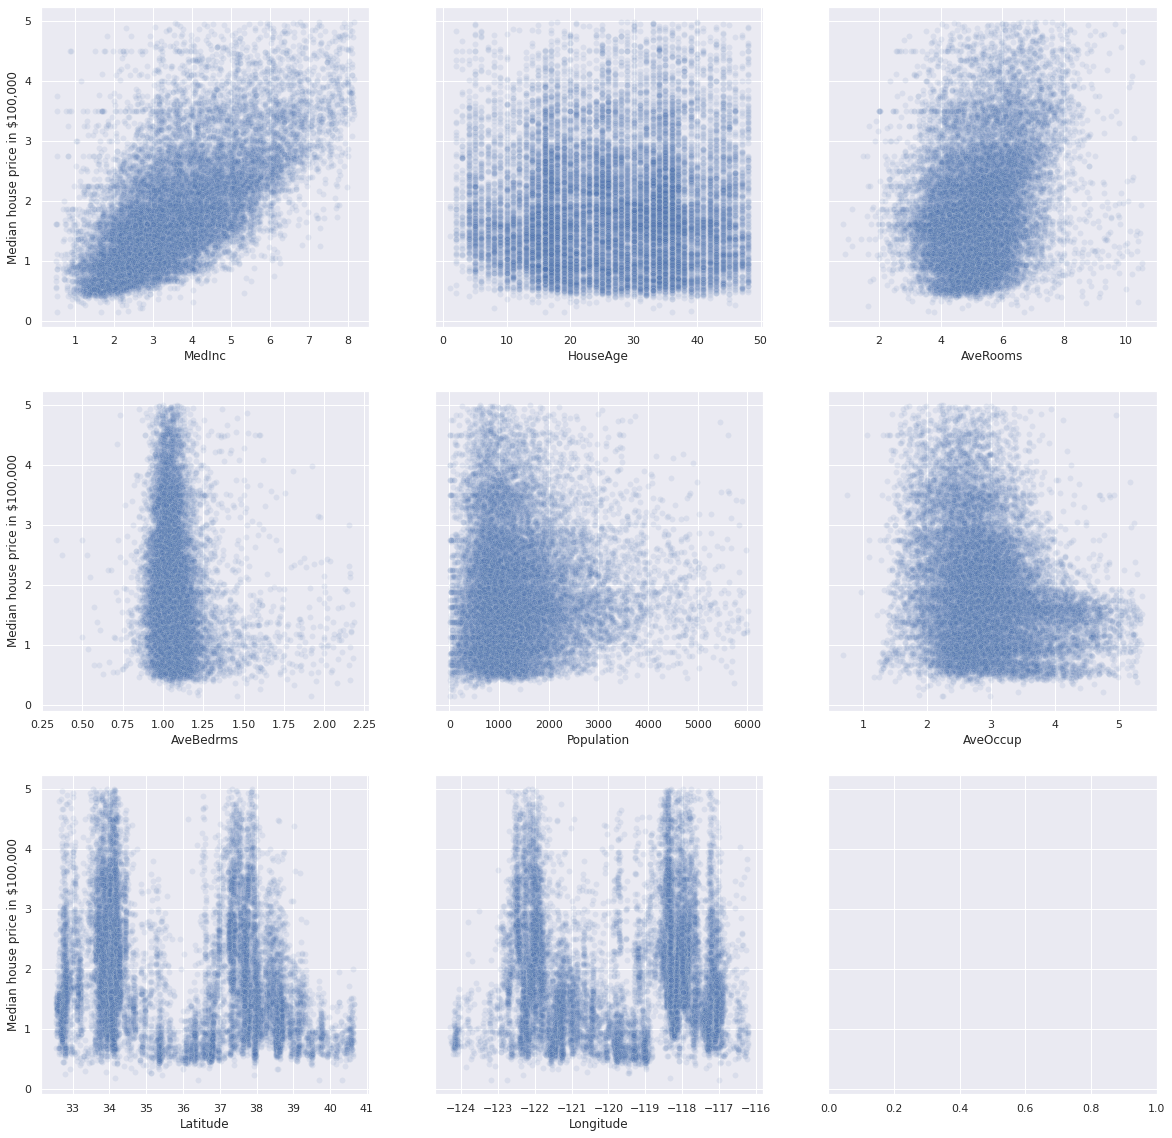

In [7]:
from seaborn import scatterplot
from matplotlib.pyplot import subplots
from numpy import percentile

# make scatterplots of all predictors with the label


def drop_outliers(data, target):
    thresh = percentile(data, 99)
    return data[data < thresh], target[data < thresh]


fig, axes = subplots(3, 3, figsize=(20, 20), sharey=True)

axe = axes.ravel()

for i, feature_name in zip(range(0, len(data.feature_names)), data.feature_names):
    x_filtered, y_filtered = drop_outliers(X_df_capped[feature_name], y_capped)
    ax = scatterplot(x=x_filtered, y=y_filtered, ax=axe[i], alpha=0.1)
    ax.set_ylabel('Median house price in $100,000')
    ax.set_xlabel(feature_name)


<AxesSubplot:>

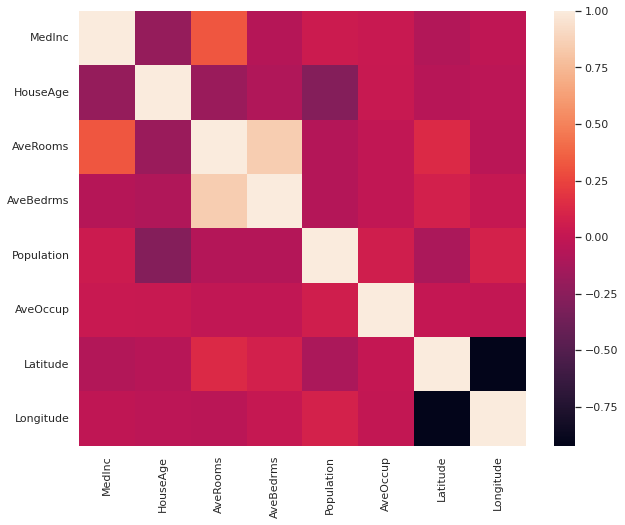

In [8]:
from seaborn import heatmap
from matplotlib.pyplot import figure

figure(figsize=(10, 8))
correlations = X_df_capped.corr()
heatmap(correlations)


In [9]:
# From the correlation matrix we can see that "AveBedrms" is highly correlated with "AveRooms"
# It might be better to drop one of those predictors (we shall drop "AveBedrms")

if ('AveBedrms' in X_df_capped.columns):
    X_df_capped = X_df_capped.drop('AveBedrms', 1)

X_df_capped.describe()

/tmp/ipykernel_31606/511722905.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_df_capped = X_df_capped.drop('AveBedrms', 1)


,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude
count,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000
mean,3.693194,26.981299,5.387533,1470.684398,3.109436,35.594189,-119.485306
std,1.570195,11.434147,2.338253,1163.197359,10.816549,2.147977,1.980966
min,0.499900,1.000000,0.846154,3.000000,0.692308,32.540000,-124.300000
25%,2.537250,17.000000,4.432009,811.000000,2.469992,33.920000,-121.550000
50%,3.465900,27.000000,5.210412,1203.000000,2.856089,34.240000,-118.450000
75%,4.616100,36.000000,5.989601,1781.000000,3.321153,37.670000,-117.970000
max,15.000100,51.000000,132.533333,35682.000000,1243.333333,41.950000,-114.310000


# Train/Test Split


In [187]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% test

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2)


In [188]:
print("Test data:", X_train.shape, y_train.shape)
print("Training data:", X_test.shape, y_test.shape)


Test data: (16512, 8) (16512,)
Training data: (4128, 8) (4128,)


# Pre-Processing


In [189]:
from sklearn.preprocessing import StandardScaler
# produce standardized predictors with mean zero and variance one
# fit the transformer in the training set and apply to the whole data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((16512, 8), (4128, 8))

In [190]:
from sklearn.preprocessing import PolynomialFeatures

# produce quadratic polynomial features from all standardized predictors
# squared values and pairwise interactions
# fit the transformer in the training set and apply to the whole data

poly_features = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly_features.transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

X_train_poly.shape, X_test_poly.shape


((16512, 45), (4128, 45))

## Fractional Ridge Regression

https://arxiv.org/abs/2005.03220

https://nrdg.github.io/fracridge/


In [191]:
# I am using pip instead of conda...
!pip install fracridge


In [192]:
from fracridge import FracRidgeRegressorCV
from sklearn.metrics import mean_squared_error, r2_score


In [193]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

# train fractional ridge on raw predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set


def run_reg(reg, X_train, y_train, X_test, y_test, print_stats=['coef_', 'alpha_', 'best_frac_']):
    reg.fit(X_train, y_train)

    for stat in print_stats:
        if stat == 'coef_':
            print('coef_:', list(zip(data.feature_names, reg.coef_)))
        else:
            print(f'{stat}:', getattr(reg, stat))

    # y_train_pred = cross_val_predict(reg, X_train, y_train)
    # y_test_pred = cross_val_predict(reg, X_test, y_test)
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)

    train_mse = round(mean_squared_error(y_train, y_train_pred), 2)
    test_mse = round(mean_squared_error(y_test, y_test_pred), 2)
    print('Train/Test MSE:', train_mse, test_mse)
    print('Train/Test RMS:', round(np.sqrt(train_mse), 2), round(np.sqrt(test_mse), 2))
    print('Train/Test R^2:', round(r2_score(y_train, y_train_pred), 2), round(r2_score(y_test, y_test_pred), 2))

    return y_train_pred, y_test_pred


In [194]:
frcv = FracRidgeRegressorCV(frac_grid=np.logspace(0, 1, 20, True))
# frcv = FracRidgeRegressorCV(frac_grid=np.arange(0, 1.05, 0.05))


y_train_pred_raw, y_test_pred_raw = run_reg(frcv, X_train, y_train, X_test, y_test)

coef_: [('MedInc', 0.511043167615518), ('HouseAge', 0.015586852940458022), ('AveRooms', -0.1763652002873926), ('AveBedrms', 0.8390108688744558), ('Population', 1.19981963975286e-05), ('AveOccup', -0.004346527019452043), ('Latitude', -0.06388473928804235), ('Longitude', -0.016323325300839568)]
alpha_: [[0.]]
best_frac_: 1.0
Train/Test MSE: 0.6 0.63
Train/Test RMS: 0.77 0.79
Train/Test R^2: 0.55 0.53


In [195]:
# train fractional ridge on stanardized predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set

y_train_pred_nrm, y_test_pred_nrm = run_reg(frcv, X_train_scaled, y_train, X_test_scaled, y_test)

# Hmm, this has a pretty bad r2-score...

coef_: [('MedInc', 0.826081040050509), ('HouseAge', 0.11676215603142409), ('AveRooms', -0.2563884975585697), ('AveBedrms', 0.29800307336758364), ('Population', -0.000777878083042461), ('AveOccup', -0.039929269015941224), ('Latitude', -0.9053277775311286), ('Longitude', -0.876241812448536)]
alpha_: [[0.]]
best_frac_: 1.0
Train/Test MSE: 4.78 4.87
Train/Test RMS: 2.19 2.21
Train/Test R^2: -2.61 -2.6


In [196]:
# train fractional ridge on standardized predictors including quadratics and interactions
# report the chosen fraction penalty
# report MSE and r-squared in test set

y_train_pred_poly, y_test_pred_poly = run_reg(frcv, X_train_poly, y_train, X_test_poly, y_test)

# Still pretty bad, I might have done something wrong


coef_: [('MedInc', 1.952546796696858), ('HouseAge', 0.9315628967067321), ('AveRooms', 0.14021656589874462), ('AveBedrms', -0.395869602822879), ('Population', 0.5833232289704294), ('AveOccup', 0.04731404051712907), ('Latitude', -2.1046164358092296), ('Longitude', -1.2549185663389961)]
alpha_: [[0.]]
best_frac_: 1.0
Train/Test MSE: 0.41 0.48
Train/Test RMS: 0.64 0.69
Train/Test R^2: 0.69 0.64


In [197]:
from seaborn import regplot

Text(0, 0.5, 'Predicted value')

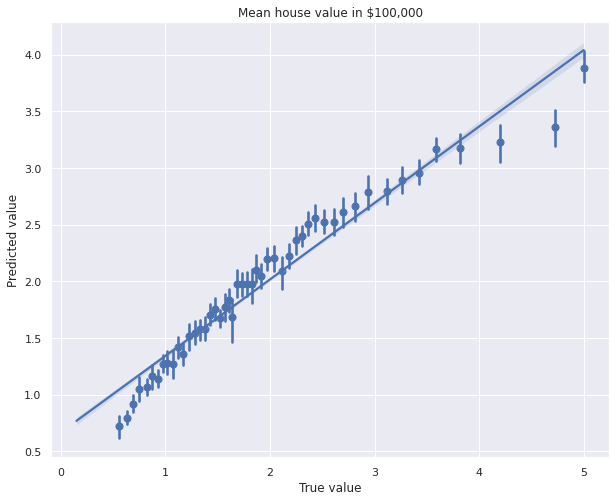

In [198]:
# report a binned regplot of the true outcome versus predictions in the test set

figure(figsize=(10, 8))
axes = regplot(x=y_test, y=y_test_pred_poly, x_bins=50)
axes.set_title('Mean house value in $100,000')
axes.set_xlabel('True value')
axes.set_ylabel('Predicted value')

**How do the results change when using different predictors? Which one do you think is the best model for this task? Explain.**


We get the best predictions with the polynomial fit ($r^2 \approx 0.65$). This might be because with `PolynomialFeatures` we also model some interactions between different predictors. The model using just the scaled version of the data performs really poorly, this might be due to programmer error (I'm not sure)

To be honest I didn't quite understand what the polynomial features does (also not really explained in the exercise sessions and I do not have a machine learning background)

Also, I seem to get better R2-scores using the "raw" data (no data cleanup performed, see `X_df_capped` and `y_capped`). I am not able to explain why though.